### Doyle Reaction Prediction Pt. 1: Reproducing Results from the Paper and Additional Folds

In this notebook, we:

1. Reproduce the results from the paper to ensure that our indexing methods are correct. Note that scikit-learn does not have an implementation of bayes generalized linear models. We won't incorporate those for comparison.

2. Complete the additional 2-folds of the out-of-sample predictions, predicting plate 1 from plates 2 and 3, and plate 2 from 3 and 4.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Import relevant scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR

# Import rpy2 to use R
from rpy2.robjects import r, pandas2ri
import rpy2.robjects as robjects
pandas2ri.activate()
readRDS = robjects.r['readRDS']

import utils
%matplotlib inline

In [2]:
# Define path and csv files
DATA_DIR = 'data/'
YIELDS_DF = 'yields.csv'
INPUTS = 'output_table.csv'      # Unscaled  data from github.com/doylelab/rxnpredict
TRAIN_DF = 'training_scaled.rds' # Scaled training data from github.com/doylelab/rxnpredict
TEST_DF = 'test_scaled.rds'      # Scaled test set data from github.com/doylelab/rxnpredict

In [3]:
# load R dataframes
train_rds = readRDS(DATA_DIR + TRAIN_DF)
test_rds  = readRDS(DATA_DIR + TEST_DF)

# convert these to pandas dataframes
train_df = pandas2ri.ri2py(train_rds)
test_df  = pandas2ri.ri2py(test_rds)

# fetch the indices of the exact test/train split
train_indices = train_df.sort_index().index - 1
test_indices = test_df.sort_index().index - 1

In [4]:
# Load the raw chemical features as input
inputs = pd.read_csv(DATA_DIR + INPUTS)

In [5]:
# In contrast to the standard practice
# The authors standard scale before datasplitting
scaler = StandardScaler()
scaler.fit(inputs)
inputs = scaler.transform(inputs)

In [6]:
# Load yield data
yields = pd.read_csv(DATA_DIR + YIELDS_DF)

# The paper removes control reactions and additive 7

yields = np.array(yields['x'])
yields = yields.reshape(3 * 32, 48)
yields = np.delete(yields, [0, 4, 8, 12, 19, 23, 27, 31], axis=0)
yields = np.delete(yields, [15, 31, 47], axis=1)
yields = yields.flatten()

# Yield data contains some NaNs to eliminate
for idx, value in enumerate(yields):
    if np.isfinite(value) == False:
        print(idx, value)
        yields[idx] = 0

696 nan
741 nan
796 nan
797 nan
884 nan


In [7]:
# Use the indices to generate train/test sets
X_train = inputs[train_indices]
y_train = yields[train_indices]

X_test = inputs[test_indices]
y_test = yields[test_indices]

In [8]:
models = [LinearRegression(),
          KNeighborsRegressor(n_neighbors=7), # use k = 7 as in papers
          LinearSVR(),
          MLPRegressor(hidden_layer_sizes=(5), # 5-neurons are used in the initial
                       activation='logistic',  # release of the paper
                       solver='sgd',
                       max_iter=10000,
                       random_state=42),
          MLPRegressor(hidden_layer_sizes=(100),
                       activation='logistic',
                       solver='sgd',
                       max_iter=10000,
                       random_state=42),
          RandomForestRegressor(n_estimators=500, # 500 trees
                                random_state=42)
         ]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)
MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=5, learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden

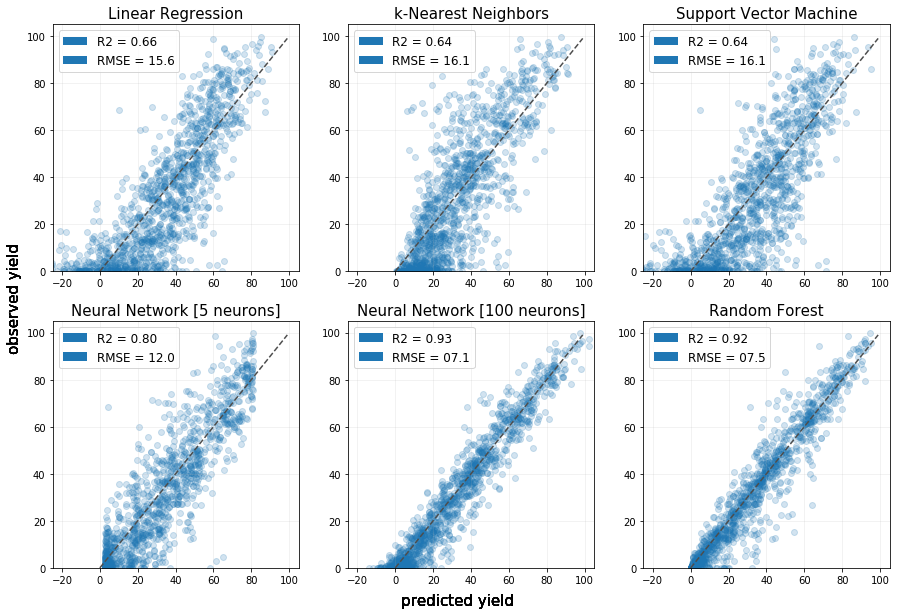

In [9]:
preds, r2_values, rmse_values  = utils.fit_models(X_train,
                                                  X_test,
                                                  y_train,
                                                  y_test,
                                                  models)
utils.plot_models(preds,
                  r2_values,
                  rmse_values,
                  y_test)

The overall values match well, and the 100-neuron neural net does very well here. There are differences between the scikit-learn implementation and the R implementation.

### Predicting Plate 3 using Plates 1 and 2

Plate three has 8 additives, whereas plates 1 and 2 have 6 additives each. Out of 3960 entries, plate three starts at 2520.

In [10]:
# Use the indices to generate train/test sets
X_plates_1_2 = inputs[:2520]
y_plates_1_2 = yields[:2520]

X_plate_3 = inputs[2520:]
y_plate_3 = yields[2520:]

In [11]:
# Fit the random forest regressor
model = RandomForestRegressor(n_estimators=500,
                              random_state=42)

model.fit(X_plates_1_2, y_plates_1_2)
preds = model.predict(X_plate_3)
r_squared = r2_score(preds, y_plate_3)
rmse = mean_squared_error(preds, y_plate_3) ** 0.5

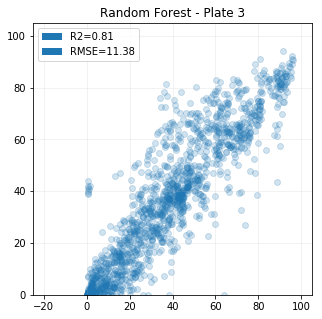

In [12]:
plt.figure(figsize=(5,5))

plt.grid(alpha=0.2)
plt.title('Random Forest - Plate 3')
        
        # add score patches
r2_patch = mpatches.Patch(label="R2={:04.2f}".format(r_squared))
rmse_patch = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
plt.xlim(-25,105)
plt.ylim(0,105)
plt.scatter(preds, y_plate_3, alpha=0.2)
plt.legend(handles=[r2_patch, rmse_patch])
plt.show()

The RMSE value matches well (11.4%) and the R2 = 0.81.

### Predicting the remaining folds

Only plate 3 is included in the paper, we'll include predictions of plates 1 and 2 for completeness, using the other two plates as the training set.

In [13]:
# Train on plates 1 and 2
X_train_3 = inputs[:2520]
y_train_3 = yields[:2520]

# Test on plate 3
X_test_3 = inputs[2520:]
y_test_3 = yields[2520:]

dataset_3 = [X_train_3, y_train_3, X_test_3, y_test_3]

# Train on plates 1 and 3
X_train_2 = np.concatenate([inputs[:1080], inputs[2520:]])
y_train_2 = np.concatenate([yields[:1080], yields[2520:]])

# Test on plate 2
X_test_2 = inputs[1080:2520]
y_test_2 = yields[1080:2520]

dataset_2 = [X_train_2, y_train_2, X_test_2, y_test_2]

# Train on plates 2 and 3
X_train_1 = inputs[1080:]
y_train_1 = yields[1080:]

# Test on plate 1
X_test_1 = inputs[:1080]
y_test_1 = yields[:1080]

dataset_1 = [X_train_1, y_train_1, X_test_1, y_test_1]

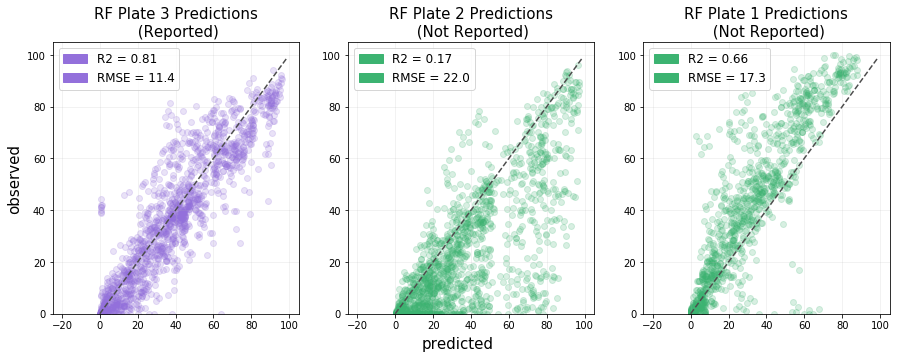

In [14]:
# Define RF models
models = [RandomForestRegressor(n_estimators=500,
                                random_state=42),
          RandomForestRegressor(n_estimators=500,
                                random_state=42),
          RandomForestRegressor(n_estimators=500,
                                random_state=42)]
datasets = [dataset_3, dataset_2, dataset_1]

predictions = []
r2_values = []
rmse_values = []

for i, (data, model) in enumerate(zip(datasets, models)):
    model.fit(data[0], data[1])
    preds = model.predict(data[2])
    r_squared = r2_score(data[3], preds)
    rmse = mean_squared_error(preds,  data[3]) ** 0.5
    
    predictions.append(preds)
    r2_values.append(r_squared)
    rmse_values.append(rmse)
    
titles = ['RF Plate 3 Predictions\n (Reported)',
          'RF Plate 2 Predictions\n (Not Reported)',
          'RF Plate 1 Predictions\n (Not Reported)']
fig = plt.figure(figsize=(15,5))
colors = ['mediumpurple','mediumseagreen','mediumseagreen']

for i, color in enumerate(colors):
    fig.add_subplot(1,3,i+1)
    plt.title(titles[i], fontsize=15)
    plt.grid(alpha=0.2)
    r2_patch = mpatches.Patch(label="R2 = {:04.2f}".format(r2_values[i]),color=color)
    rmse_patch = mpatches.Patch(label="RMSE = {:04.1f}".format(rmse_values[i]), color=color)
    plt.xlim(-25,105)
    plt.ylim(0,105)
    plt.scatter(predictions[i], datasets[i][3], alpha=0.2, c=color)
    plt.legend(handles=[r2_patch, rmse_patch], fontsize=12)
    plt.plot(np.arange(100), np.arange(100), ls="--", c=".3")
fig.text(0.5, 0.04, 'predicted', ha='center', va='center', fontsize=15)
fig.text(0.09, 0.5, 'observed', ha='center', va='center', rotation='vertical', fontsize=15)
plt.savefig('plots/plates_paper.png', dpi = 300)
plt.show()

The other folds of this three-fold out-of-sample cross-validation experiment do not perform as well as just the third fold.